- Подключаем необходимые библиотеки для работы с данными, моделями и валидацией.
- Настраиваем базовую визуализацию для разведочного анализа.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import os
for dirname, _, filenames in os.walk(''):
    for filename in filenames:
        print(os.path.join(dirname, filename))

- Загружаем датасеты (обучающий/тестовый) в `pandas.DataFrame`.
- Проверяем корректность путей/разделителей и приведение типов при чтении.

In [7]:
X = pd.read_parquet('training_data.parquet')
y = X.Label
X_test = pd.read_parquet('testing_data.parquet')
X.drop(['Label'], axis=1, inplace=True)

In [8]:
X.head()

,Gen_1,Gen_2,Gen_3,Gen_4,Gen_5,Gen_6,Gen_7,Gen_8,Gen_9,Gen_10,...,Gen_23,Gen_24,Gen_25,Gen_26,Gen_27,Gen_28,Gen_29,Gen_30,Gen_31,Gen_32
0,-0.612437,0.141487,0.458533,-0.071467,0.708214,-0.477746,0.856017,-0.342309,0.287124,-0.098588,...,0.076852,1.290434,0.953137,0.802774,0.854350,0.233216,0.441941,-0.736140,0.018850,-0.008982
1,-0.861413,-0.996076,-0.306018,-0.010211,-0.879153,0.413864,-0.074583,0.085765,0.643734,0.300968,...,0.251588,-3.594071,0.801640,-0.380052,-0.292074,-0.135045,0.871354,0.223270,-0.796132,-0.664492
2,-1.181441,-0.812953,-0.508014,-0.696508,-0.390999,-0.095552,0.367309,-0.873542,0.041671,0.031417,...,0.242244,-8.449327,-0.086694,0.770491,-0.083252,-0.428152,-1.244436,0.137318,0.165100,0.923372
3,0.163951,-0.192090,-0.447321,0.547369,-0.449285,0.777312,-0.999865,0.151199,-0.603120,-0.281460,...,0.063538,-7.174547,0.473732,0.047760,-0.058842,-0.968084,0.624607,0.214737,-0.006062,0.074464
4,0.071631,0.612905,0.649803,0.385430,-0.424744,-0.021610,-0.605742,-0.848004,-0.504312,0.024626,...,0.592421,-8.291042,-1.029130,0.409040,0.641534,0.902917,-0.933028,0.756775,-1.177836,-0.724628


- Делим данные на обучение/валидацию, чтобы честно оценивать качество и избегать переобучения.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=228)

- Обучаем **логистическую регрессию** — по условию задачи допускается только этот алгоритм.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model_1 = LogisticRegression(random_state=228)
model_1.fit(X_train, y_train)
prediction = model_1.predict(X_valid)
accuracy = accuracy_score(y_valid, prediction)
accuracy

0.54375

- Подключаем **Random Forest** чтобы посмотреть как она справляется

In [11]:
from sklearn.ensemble import RandomForestClassifier

model_2 = RandomForestClassifier(random_state=228)
model_2.fit(X_train, y_train)
prediction = model_2.predict(X_valid)
accuracy = accuracy_score(y_valid, prediction)
accuracy

0.98125

- Смотрим на какие данные она отталкивалась

<Axes: >

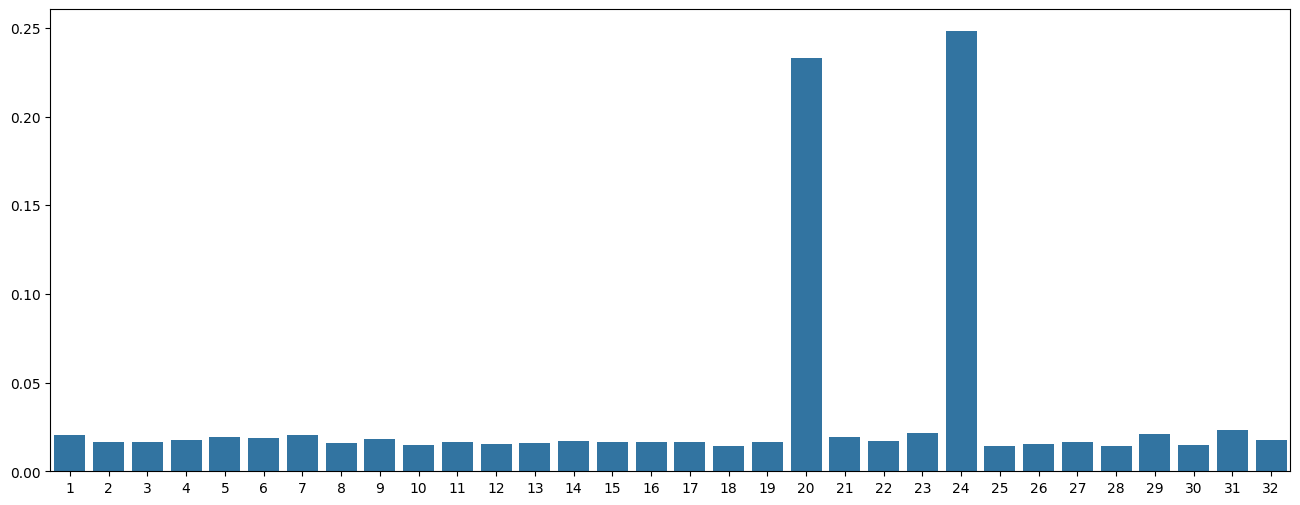

In [12]:
imp = model_2.feature_importances_
plt.figure(figsize=(16,6))
cols = [i for i in range(1, 33)] # Gen_1 ... Gen_32 but shorter
sns.barplot(x=cols, y=imp)

- Видим что гены 20 и 24 очень сильно влияют на модельку. Поэтому давайте посмотрим чисто эти гены

<Axes: xlabel='Gen_20', ylabel='Gen_24'>

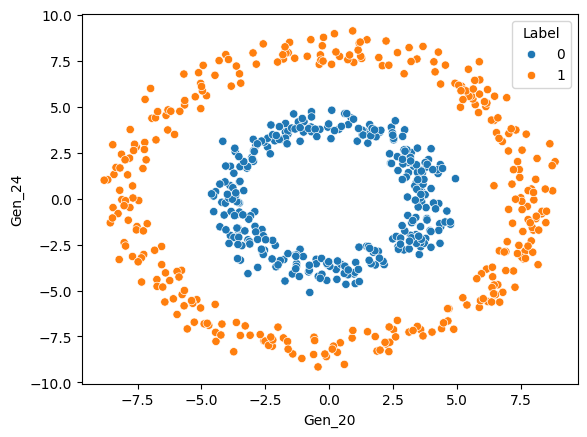

In [13]:
sns.scatterplot(x=X_train.Gen_20, y=X_train.Gen_24, hue=y_train)

- Четко видим что это просто x^2 + y^2. Но все таки давайте посмотрим как она справляется с валид датой.

In [14]:
def get_feature(df):
    return np.array(df.Gen_20 ** 2 + df.Gen_24 ** 2).reshape(-1, 1)
    
model_3 = LogisticRegression(random_state=228)
new_X_train = get_feature(X_train)
new_X_valid = get_feature(X_valid)
model_3.fit(new_X_train, y_train)
prediction = model_3.predict(new_X_valid)
accuracy = accuracy_score(y_valid, prediction)
accuracy

1.0

- Отлично! Теперь треним модельку на всех данных и выводим наш предикт

In [15]:
model_final = LogisticRegression(random_state=228)
full_X_train = get_feature(X)
model_final.fit(full_X_train, y)
X_test = get_feature(X_test)
prediction = model_final.predict(X_test)
prediction

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0])

In [17]:
submission = pd.read_csv('sample_submission.csv')
submission.Label=prediction
submission.to_csv('submission.csv', index=False)